[View in Colaboratory](https://colab.research.google.com/github/shravankumar9892/coloi/blob/master/coloi.ipynb)

# COLOI
You can visit the project webiste through this link: [COLOI](https://sites.google.com/view/coloi/)

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# Authenticate
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Loading image file into colab

image_downloaded = drive.CreateFile({'id':'1HzIKgbXGKcAvwsygYOTb4S3Sqxtn96ns'})
image_downloaded.GetContentFile('man.jpeg')

# **Object Detection**
![Inception](https://www.tensorflow.org/images/AlexClassification.png)

In [0]:
# Libraries

import keras
from keras.applications import inception_v3
from keras.applications.imagenet_utils import decode_predictions
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Enter the image file: man.jpeg


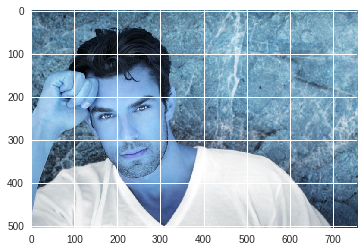

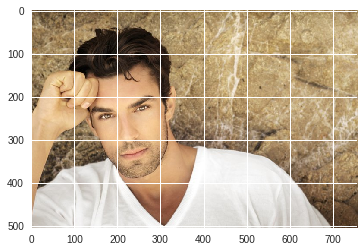

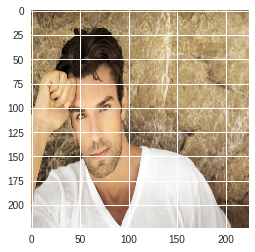

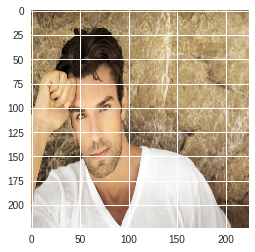

In [39]:
# Taking input

image_file = input('Enter the image file: ')
img = cv2.imread(image_file, 1) # Remember wrong image name will not give you an error.
plt.imshow(img)
plt.show()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting bgr into rgb values.
plt.imshow(img)
plt.show()

img = cv2.resize(img, (224, 224)) # Resizing
plt.imshow(img)
plt.show()
# till here it's correct
# Expanding image dimension along axis 0
img = np.expand_dims(img, axis=0)
plt.imshow(np.uint8(img[0]))
plt.show()

img = img.astype(float)

In [0]:
# Process the image by subtracting the mean of R, G, B respectively with the elements of the image array

input_img = inception_v3.preprocess_input(img.copy()) 

In [0]:
# Loading the pre-trained model

model = inception_v3.InceptionV3(weights='imagenet')

In [0]:
# Prediction
predictions = model.predict(input_img)
predictions = decode_predictions(predictions)

In [48]:
print('This image contains: \n\n' + predictions[0][0][1]+ ' with a % probability of: ' + str(predictions[0][0][2]*100))
print(predictions[0][1][1]+ ' with a % probability of: ' + str(predictions[0][1][2]*100))
print(predictions[0][2][1]+ ' with a % probability of: ' + str(predictions[0][2][2]*100))
print(predictions[0][3][1]+ ' with a % probability of: ' + str(predictions[0][3][2]*100))
print(predictions[0][4][1]+ ' with a % probability of: ' + str(predictions[0][4][2]*100))

This image contains: 

groom with a % probability of: 98.27573299407959
hair_spray with a % probability of: 0.277883093804121
gown with a % probability of: 0.26049839798361063
kimono with a % probability of: 0.2170726889744401
bikini with a % probability of: 0.20790579728782177


# Color Spaces
![Color Space](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRzCvTgNUnzRZzQ82_sTKnYj0GWqktiU8GlFNRr9TEPIDXSDPg5)

#### Various Types of Color Spaces available, run the code cell below

In [0]:
def flags():
  # To get flags, just run following code cell :
  flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
  print(flags)
  return None

#### Taking the input

In [53]:
image_file = input('Enter the image file: ')
img = cv2.imread(image_file, 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Enter the image file: man.jpeg


#### Color Space Conversion

In [0]:
# Find suitable flag values from the function flags

def color_spaces(image, flag, save = False, show = True):
  img = cv2.cvtColor(image, flag)
  if show == True:
    plt.imshow(img)
    plt.show()
  else:
    pass
  if save == True:
    cv2.imwrite(input('Image shall be saved with which name? ', img))

# Image Colorization
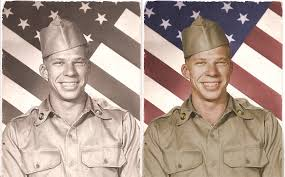